In [60]:
import torch
import torch.nn.functional as F
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from network import VAE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Task 1

In [61]:
# Helper functions to not make the training loop to big
def vae_loss(x_recon, x, mean, log_var, kl_weight=0.001):
    x = x.view(x.size(0), -1)
    x_recon = x_recon.view(x_recon.size(0), -1)
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    batch_size = x.size(0)
    return (recon_loss + kl_weight * kl_div) / batch_size

def plot_samples(model, epoch, device):
    model.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(1, 10, figsize=(10, 1))
        for i in range(10):
            sample = model.sample(i, device).cpu().squeeze()
            axes[i].imshow(sample, cmap='gray')
            axes[i].axis('off')
        plt.show()

Epoch 1/5


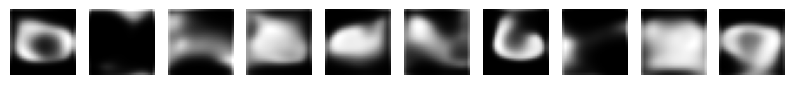

Epoch 2/5


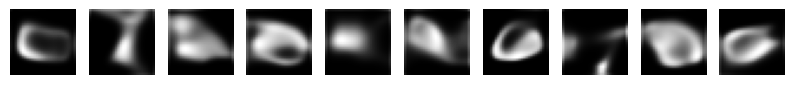

Epoch 3/5


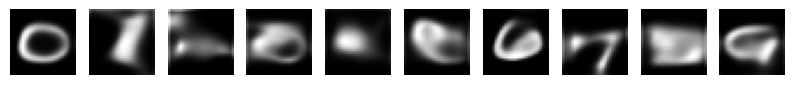

Epoch 4/5


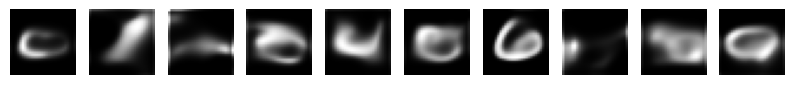

Epoch 5/5


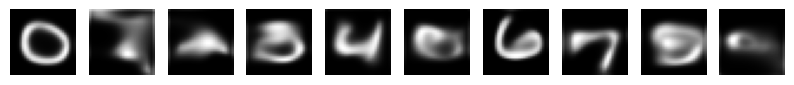

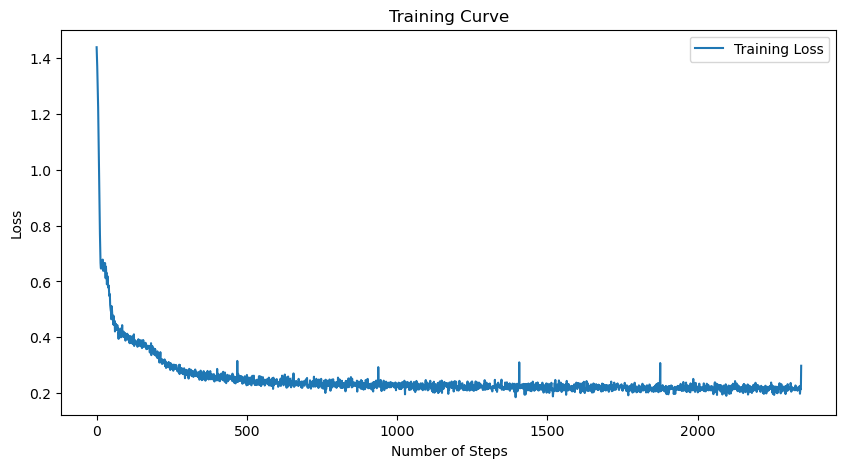

In [62]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor() 
])

# Load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_1 = VAE().to(device)
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

num_epochs = 5
kl_weight = 0.0001
step_losses = []

for epoch in range(num_epochs):
    model_1.train()
    train_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        x_recon, mean, log_var = model_1(x, y)
        loss = vae_loss(x_recon, x, mean, log_var, kl_weight) / x.size(0)
        loss.backward()
        optimizer.step()
        step_losses.append(loss.item())
    print(f'Epoch {epoch + 1}/{num_epochs}')
    
    plot_samples(model_1, epoch, device)

plt.figure(figsize=(10, 5))
plt.plot(step_losses, label='Training Loss')
plt.xlabel('Number of Steps')
plt.ylabel('Loss')
plt.title('Training Curve')
plt.legend()
plt.show()

# Task 2

In [63]:
def reconstruction_loss(x_recon, x):
    x = x.view(x.size(0), -1)
    x_recon = x_recon.view(x_recon.size(0), -1)
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    return recon_loss

def kl_divergence(mean, log_var):
    return -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

In [64]:
def train_vae(model, train_loader, optimizer, loss_fn, num_epochs=5, kl_weight=0.001):
    model.train()
    epoch_losses = []
    
    for epoch in range(num_epochs):
        train_loss = 0
        num_batches = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            x_recon, mean, log_var = model(x, y)
            if loss_fn == 'recon':
                loss = reconstruction_loss(x_recon, x) / x.size(0)
            elif loss_fn == 'kl':
                loss = kl_divergence(mean, log_var) / x.size(0)
            else:
                loss = vae_loss(x_recon, x, mean, log_var, kl_weight) / x.size(0)
            loss.backward()
            train_loss += loss.item() * x.size(0)
            num_batches += x.size(0)
            optimizer.step()
        
        avg_train_loss = train_loss / num_batches
        epoch_losses.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')
    
    return model, epoch_losses



def visualize_latent_space(model, data_loader, device, loss_type):
    model.eval()
    latents, labels = [], []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            z = model.sample_latent(x, y)
            latents.append(z.cpu().numpy())
            labels.append(y.cpu().numpy())

    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=latents[:, 0], y=latents[:, 1], hue=labels, palette="tab10", legend='full', s=60, alpha=0.7)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title(f'Latent Space Visualization with {loss_type}')
    plt.show()

In [65]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Epoch [1/5], Loss: 49.1056
Epoch [2/5], Loss: 30.5328
Epoch [3/5], Loss: 28.9755
Epoch [4/5], Loss: 28.3657
Epoch [5/5], Loss: 27.9519


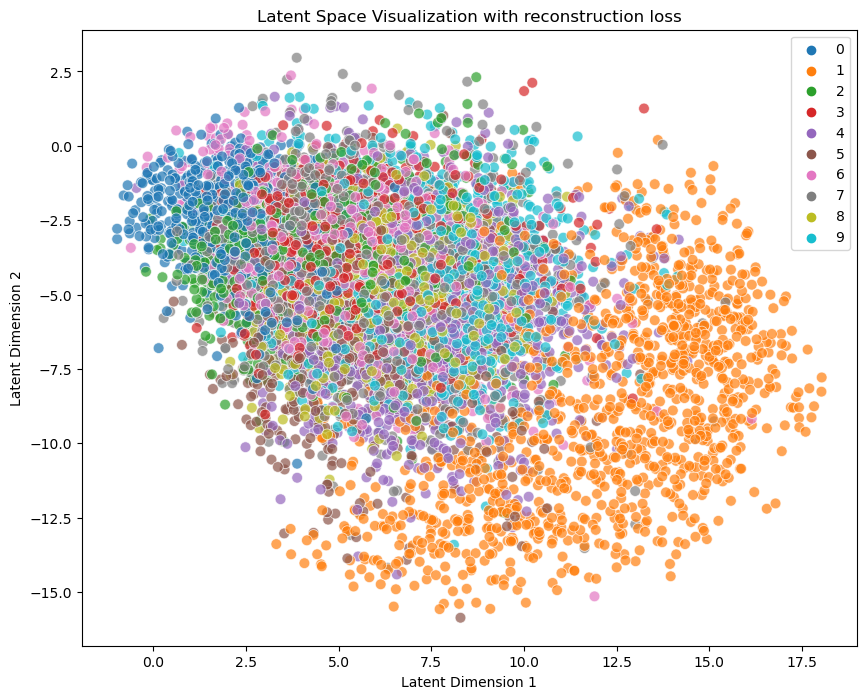

In [66]:
model_2_1 = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model_2_1.parameters(), lr=0.001)
model_2_1, recon_losses = train_vae(model_2_1, train_loader, optimizer, loss_fn='recon')
visualize_latent_space(model_2_1, test_loader, device, 'reconstruction loss')

Epoch [1/5], Loss: 0.0003
Epoch [2/5], Loss: 0.0000
Epoch [3/5], Loss: 0.0000
Epoch [4/5], Loss: 0.0000
Epoch [5/5], Loss: 0.0000


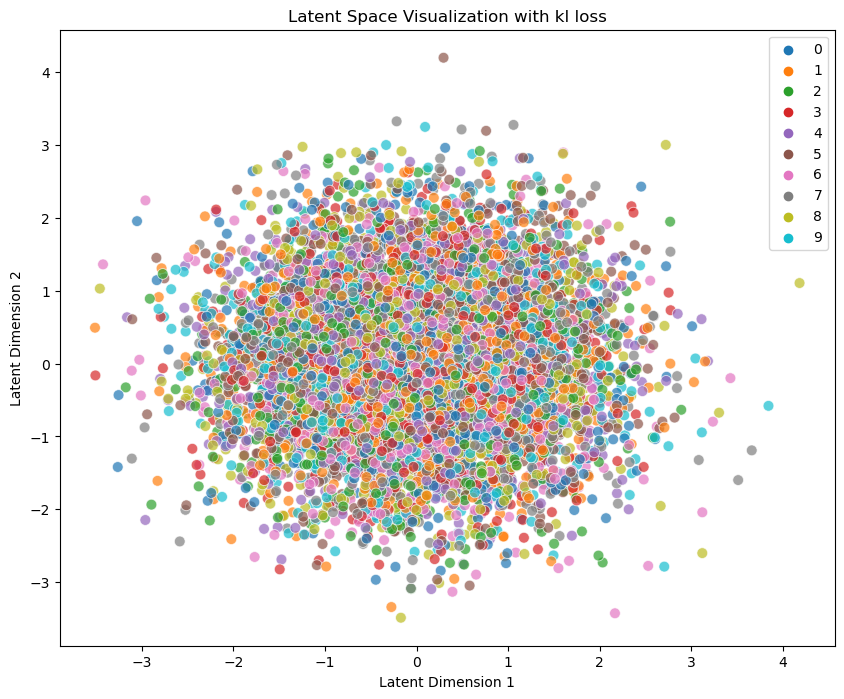

In [67]:
model_2_2 = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model_2_2.parameters(), lr=0.001)
model_2_2, kl_losses = train_vae(model_2_2, train_loader, optimizer, loss_fn='kl')
visualize_latent_space(model_2_2, test_loader, device, 'kl loss')

Epoch [1/5], Loss: 0.3935
Epoch [2/5], Loss: 0.2419
Epoch [3/5], Loss: 0.2277
Epoch [4/5], Loss: 0.2225
Epoch [5/5], Loss: 0.2191


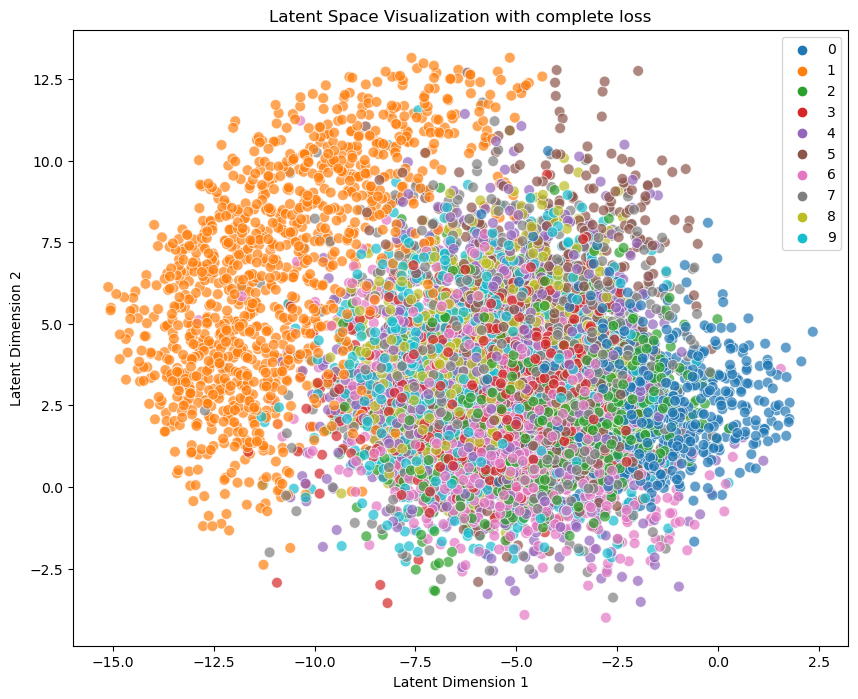

In [68]:
model_2_3 = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model_2_3.parameters(), lr=0.001)
model_2_3, full_losses = train_vae(model_2_3, train_loader, optimizer, loss_fn='full', kl_weight=0.001)
visualize_latent_space(model_2_3, test_loader, device, 'complete loss')

# Task 3

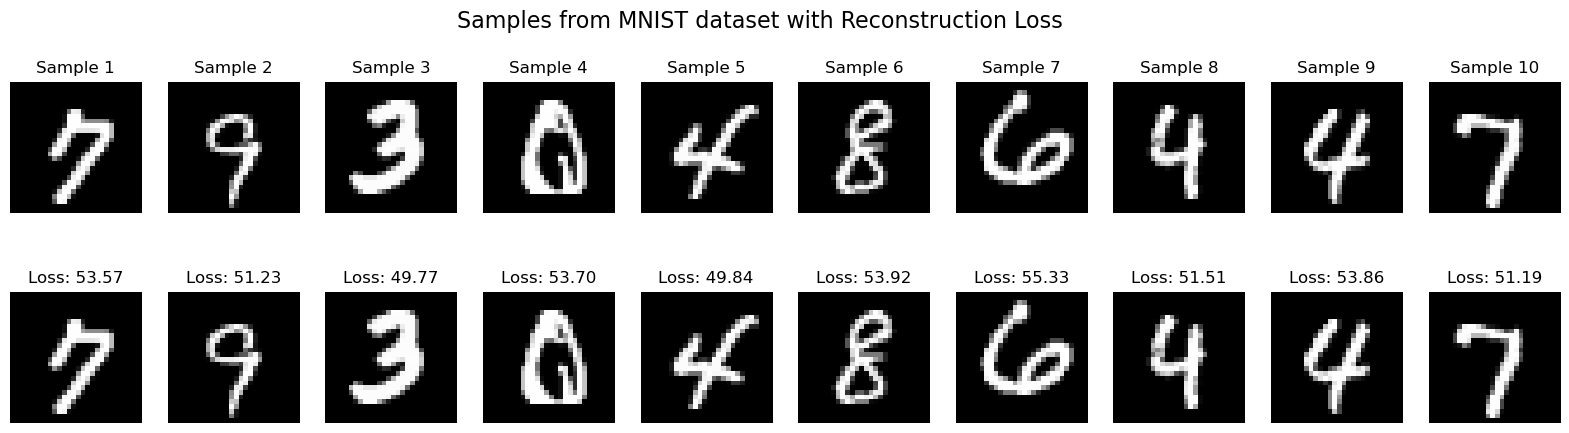

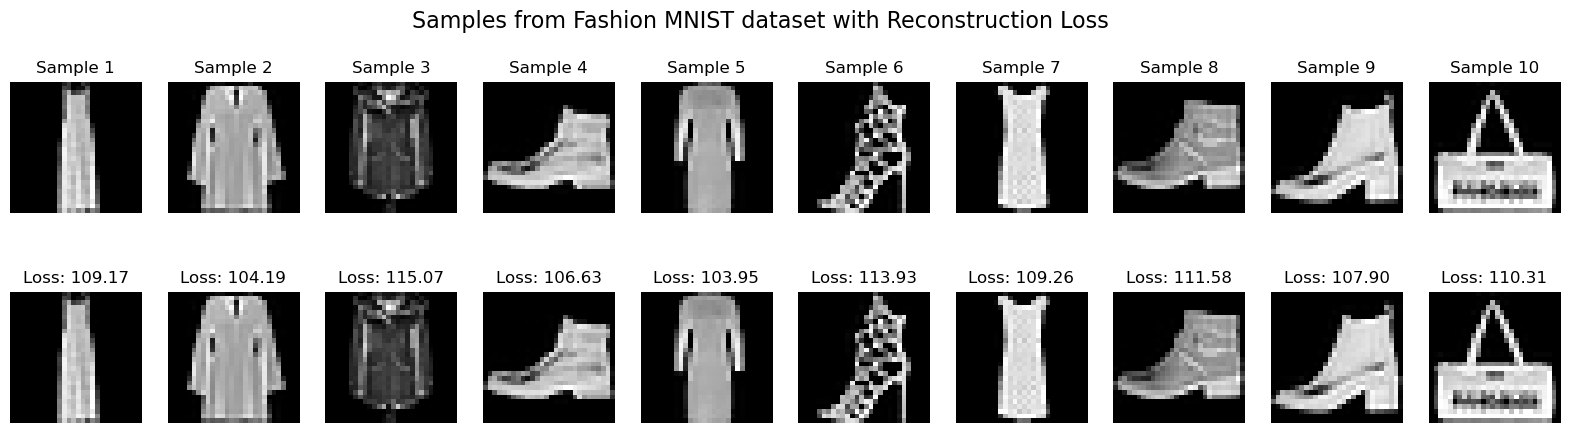

In [69]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
# Download Fashion MNIST dataset
fashion_mnist_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)

# Download MNIST dataset
mnist_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

batch_size = 128
fashion_mnist_loader = DataLoader(fashion_mnist_dataset, batch_size=batch_size, shuffle=True)
mnist_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

def compute_reconstruction_loss(model, data_loader):
    model.eval()
    reconstruction_losses = []
    images = []
    with torch.no_grad():
        for i, (x, _) in enumerate(data_loader):
            x = x.to(device)
            # Pass dummy labels (0s) for y since our model expects it
            dummy_labels = torch.zeros(x.size(0), dtype=torch.long, device=device)
            recon_x, mean, log_var = model(x, dummy_labels)
            loss = vae_loss(recon_x, x, mean, log_var, kl_weight=0.001)
            reconstruction_losses.append(loss.cpu().numpy())
            images.append(x.cpu())
            if len(images) >= 10:  # Collect 10 samples from the dataset
                break
    images = torch.cat(images[:10], dim=0)
    return images, reconstruction_losses[:10]


mnist_images, mnist_reconstruction_losses = compute_reconstruction_loss(model_1, mnist_loader)
fashion_mnist_images, fashion_mnist_reconstruction_losses = compute_reconstruction_loss(model_1, fashion_mnist_loader)

def plot_samples_with_reconstruction_loss(dataset_images, reconstruction_losses, dataset_name):
    num_samples = 10
    fig, axs = plt.subplots(2, num_samples, figsize=(20, 5))
    for i in range(num_samples):
        axs[0, i].imshow(dataset_images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title(f'Sample {i+1}')

        axs[1, i].imshow(dataset_images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        axs[1, i].axis('off')
        axs[1, i].set_title(f'Loss: {reconstruction_losses[i]:.2f}')

    fig.suptitle(f'Samples from {dataset_name} dataset with Reconstruction Loss', fontsize=16)
    plt.show()


plot_samples_with_reconstruction_loss(mnist_images, mnist_reconstruction_losses, 'MNIST')

plot_samples_with_reconstruction_loss(fashion_mnist_images, fashion_mnist_reconstruction_losses, 'Fashion MNIST')

